# Journal Profiling Part 2: Impact Metrics

This Python notebook shows how to use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) to extract [publications data ](https://docs.dimensions.ai/dsl/datasource-publications.html) for a specific journal, as well its authors and affiliations.

This tutorial is the second of a series that uses the data extracted in order to generate a 'journal profile' report. See the [API Lab homepage](https://api-lab.dimensions.ai/) for the other tutorials in this series.


In this notebook we are going to:

* Load the researchers data previously extracted
* Enrich it by building a dataset focusing on their impact in terms of no of papers, citations etc.. 
* Visualize the results with plotly to have a quick overview of the results 

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [9]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.shortcuts import *
import os, sys, time, json
from tqdm.notebook import tqdm
import pandas as pd
import plotly.express as px
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)
#

print("==\nLogging in..")
# https://github.com/digital-science/dimcli#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  USERNAME = getpass.getpass(prompt='Username: ')
  PASSWORD = getpass.getpass(prompt='Password: ')    
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
else:
  USERNAME, PASSWORD  = "", ""
  dimcli.login(USERNAME, PASSWORD, ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.7.4.2)
Connected to: https://app.dimensions.ai - DSL v1.27
Method: dsl.ini file


In [10]:
#
# create output data folder
FOLDER_NAME = "journal-profile-data"
if not(os.path.exists(FOLDER_NAME)):
    os.mkdir(FOLDER_NAME)
    
def save(df,filename_dot_csv):
    df.to_csv(FOLDER_NAME+"/"+filename_dot_csv, index=False)

## Measuring the Impact of Researchers within a Journal

Goal: from the list of authors and publications we previously extracted, we want to create a new dataset focused on **researchers** with the following information:
* number of papers
* citations median 
* altmetric median 
* last publication year 

This data will allow to determine the 'impact' of a researcher within the journal.

### Load the publications and authors data previously saved

**NOTE** If you are using Google Colab or don't have the data available, just do the following: 
1. open up the 'Files' panel in Google Colab and create a new folder `journal-profile-data`
2. grab this [file](https://github.com/digital-science/dimensions-api-lab/tree/master/cookbooks/2-publications/journal-profile-data.zip), unzip it, open the enclosed folder and upload the files called `1_publications.csv` and `1_publications_authors.csv` to Google Colab ('Upload' menu or also by dragging then inside the panel window)
3. move the files inside the `journal-profile-data` folder you just created


In [11]:
dfpubs = pd.read_csv(FOLDER_NAME+"/1_publications.csv")
authors = pd.read_csv(FOLDER_NAME+"/1_publications_authors.csv")

In [12]:
# replace empty values with 0 so to allow bulk calculations
dfpubs = dfpubs.fillna(0)
authors = authors.fillna(0)

### Isolate the Researchers data (= authors with an ID)

In [13]:
researchers = authors.query("researcher_id!=0")
print("Researchers total:",  len(researchers))
researchers.head(10)

Researchers total: 36138


,first_name,last_name,corresponding,orcid,current_organization_id,researcher_id,affiliations,pub_id
68,Valeriia,Haberland,0,['0000-0002-3874-0683'],grid.5337.2,ur.013006426255.03,"[{'id': 'grid.5337.2', 'name': 'University of ...",pub.1130642727
70,Venexia,Walker,0,['0000-0001-5064-446X'],grid.5337.2,ur.012371007265.42,"[{'id': 'grid.5337.2', 'name': 'University of ...",pub.1130642727
71,Philip C.,Haycock,0,['0000-0001-5001-3350'],grid.5337.2,ur.0774615111.82,"[{'id': 'grid.5337.2', 'name': 'University of ...",pub.1130642727
72,Mark R.,Hurle,0,0,grid.418019.5,ur.07635505004.02,"[{'id': 'grid.418019.5', 'name': 'GlaxoSmithKl...",pub.1130642727
73,Alex,Gutteridge,0,['0000-0001-7515-634X'],grid.418236.a,ur.0575726100.19,"[{'id': 'grid.418236.a', 'name': 'GlaxoSmithKl...",pub.1130642727
74,Pau,Erola,0,['0000-0003-4440-0068'],grid.5337.2,ur.0707141512.36,"[{'id': 'grid.5337.2', 'name': 'University of ...",pub.1130642727
79,James R.,Staley,0,0,grid.5337.2,ur.01220463241.34,"[{'id': 'grid.5337.2', 'name': 'University of ...",pub.1130642727
80,Benjamin,Elsworth,0,['0000-0001-7328-4233'],grid.5337.2,ur.0761204563.29,"[{'id': 'grid.5337.2', 'name': 'University of ...",pub.1130642727
81,Stephen,Burgess,0,['0000-0001-5365-8760'],grid.5335.0,ur.01223207223.05,"[{'id': 'grid.5335.0', 'name': 'University of ...",pub.1130642727
82,Benjamin B.,Sun,0,0,grid.5335.0,ur.07654011070.76,"[{'id': 'grid.5335.0', 'name': 'University of ...",pub.1130642727


### Enrich the data with Impact Statistics

First, let's pivot on the researcher ID field to eliminate duplicates and count them 

In [14]:
researchers_impact = researchers[['researcher_id', 'pub_id']].groupby('researcher_id', as_index=False).count().sort_values(by=['pub_id'], ascending=False).reset_index(drop=True)
researchers_impact.rename(columns={"pub_id": "pubs"}, inplace=True)
researchers_impact.head(10)

,researcher_id,pubs
0,ur.0723426172.10,63
1,ur.01277776417.51,45
2,ur.0641525362.39,35
3,ur.01247426430.47,33
4,ur.01317433110.75,33
5,ur.01313145634.66,32
6,ur.01264737414.70,31
7,ur.014377465057.81,30
8,ur.0637651205.48,29
9,ur.01174076626.46,28


Second, for each researcher ID we can query all of his/her publications so to calculate the following metrics: 

* citations median 
* altmetric median 
* last publication year 

Also, we add a new field with the Dimensions URL of the researcher, as it can be handy later on to open up its profile page online.


In [15]:

def get_name_surname(researcher_id):
    """
    eg
    >>> get_name_surname("ur.0723426172.10")
    'Kari Stefansson'
    """
    q = "researcher_id=='%s'" % researcher_id
    x = researchers.query(q)['first_name'].value_counts().idxmax()
    y = researchers.query(q)['last_name'].value_counts().idxmax()
    return f"{x} {y}"


# def dimensions_url(researcher_id):
#     return f"https://app.dimensions.ai/discover/publication?and_facet_researcher={researcher_id}"

fullnames, citations, altmetric, last_year, urls = [], [], [], [], []

for i, row in tqdm(researchers_impact.iterrows(), total=researchers_impact.shape[0]):
    q = "researcher_id=='%s'" % row['researcher_id']
    pub_ids = list(researchers.query(q)['pub_id'])
    fullnames.append(get_name_surname(row['researcher_id']))
    citations.append(dfpubs[dfpubs['id'].isin(pub_ids)]['times_cited'].mean())
    altmetric.append(dfpubs[dfpubs['id'].isin(pub_ids)]['altmetric'].mean())
    last_year.append(dfpubs[dfpubs['id'].isin(pub_ids)]['year'].max())
    urls.append(dimensions_url(row['researcher_id']))

researchers_impact['full_name'] = fullnames
researchers_impact['citations_mean'] = citations
researchers_impact['altmetric_mean'] = altmetric
researchers_impact['last_pub_year'] = last_year
researchers_impact['url'] = urls
# finally..
print("Researchers total:",  len(researchers_impact))
researchers_impact.head(10)


Researchers total: 19565


,researcher_id,pubs,full_name,citations_mean,altmetric_mean,last_pub_year,url
0,ur.0723426172.10,63,Kari Stefansson,129.555556,229.603175,2020,https://app.dimensions.ai/discover/publication...
1,ur.01277776417.51,45,Unnur Thorsteinsdottir,93.088889,160.622222,2019,https://app.dimensions.ai/discover/publication...
2,ur.0641525362.39,35,Gonçalo R Abecasis,134.257143,138.514286,2020,https://app.dimensions.ai/discover/publication...
3,ur.01247426430.47,33,Gudmar Thorleifsson,94.121212,171.878788,2019,https://app.dimensions.ai/discover/publication...
4,ur.01317433110.75,33,Caroline Hayward,157.333333,296.212121,2020,https://app.dimensions.ai/discover/publication...
5,ur.01313145634.66,32,Andres Metspalu,202.000000,369.281250,2019,https://app.dimensions.ai/discover/publication...
6,ur.01264737414.70,31,Tõnu Esko,177.000000,384.548387,2020,https://app.dimensions.ai/discover/publication...
7,ur.014377465057.81,30,Benjamin M. Neale,271.900000,169.233333,2020,https://app.dimensions.ai/discover/publication...
8,ur.0637651205.48,29,Daniel F Gudbjartsson,85.448276,149.689655,2019,https://app.dimensions.ai/discover/publication...
9,ur.01174076626.46,28,André G. Uitterlinden,117.107143,298.535714,2019,https://app.dimensions.ai/discover/publication...


Save the data

In [16]:
save(researchers_impact, "2_researchers_impact_metrics.csv")

## Couple of Dataviz

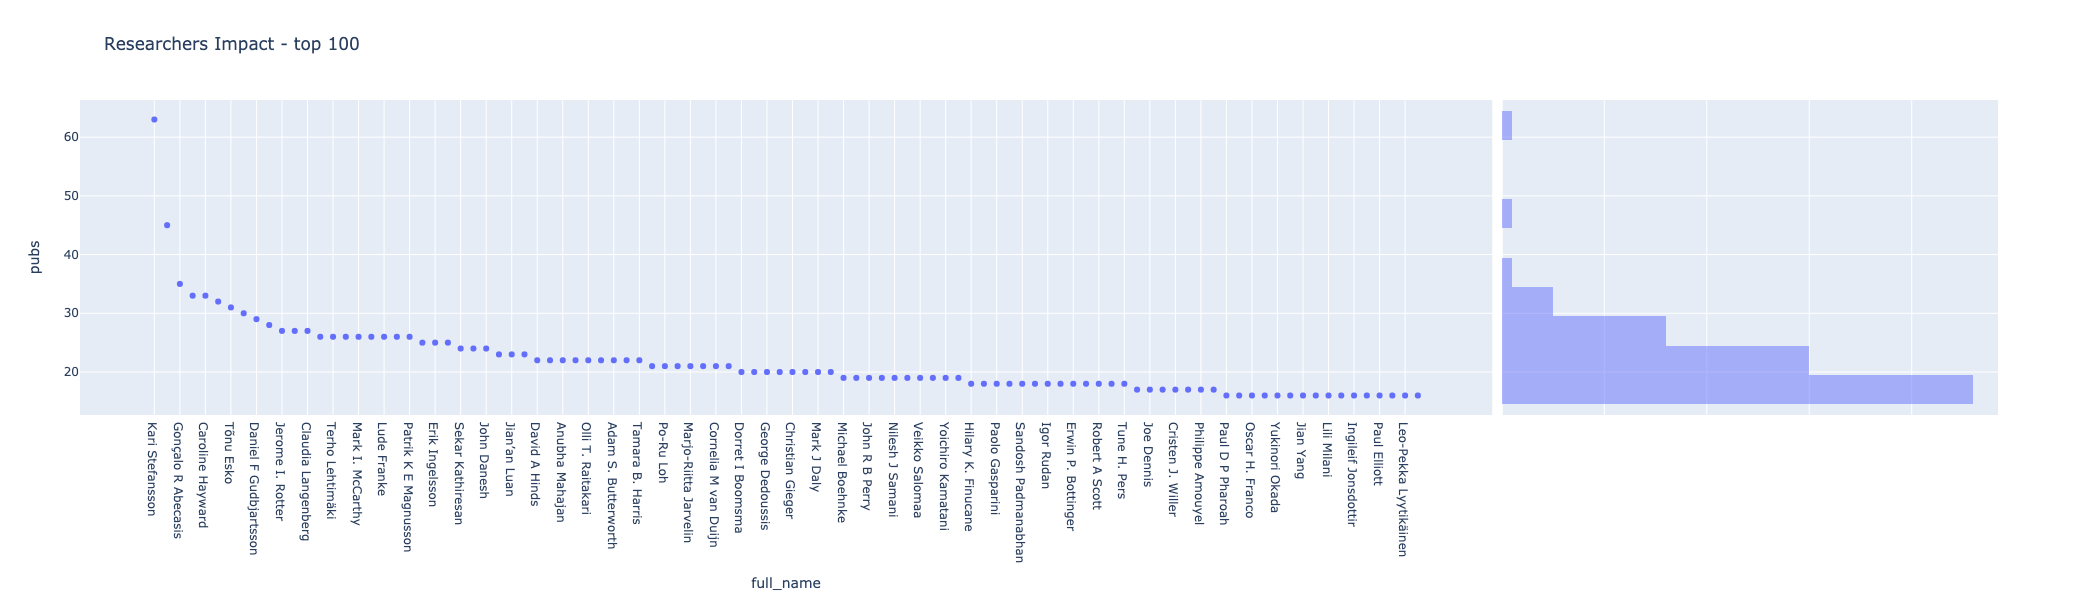

In [20]:
top100 = researchers_impact[:100]
px.scatter(top100, 
           x="full_name", y="pubs", 
           hover_name="full_name", 
           hover_data=['citations_mean', 'altmetric_mean'], 
           marginal_y="histogram", 
           height=600,
           title="Researchers Impact - top 100")

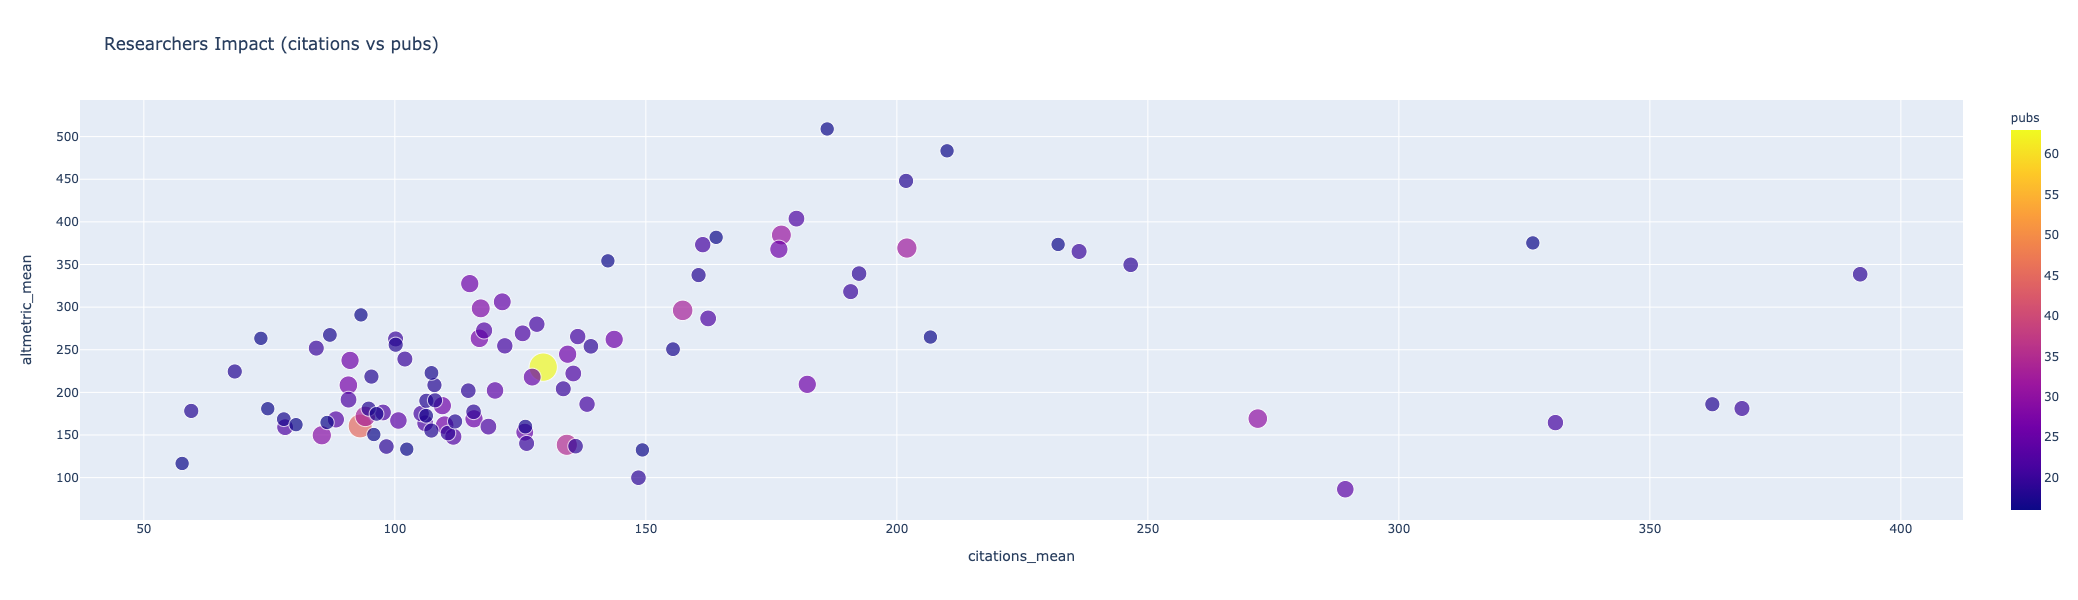

In [21]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           height=600,
           title="Researchers Impact (citations vs pubs)")

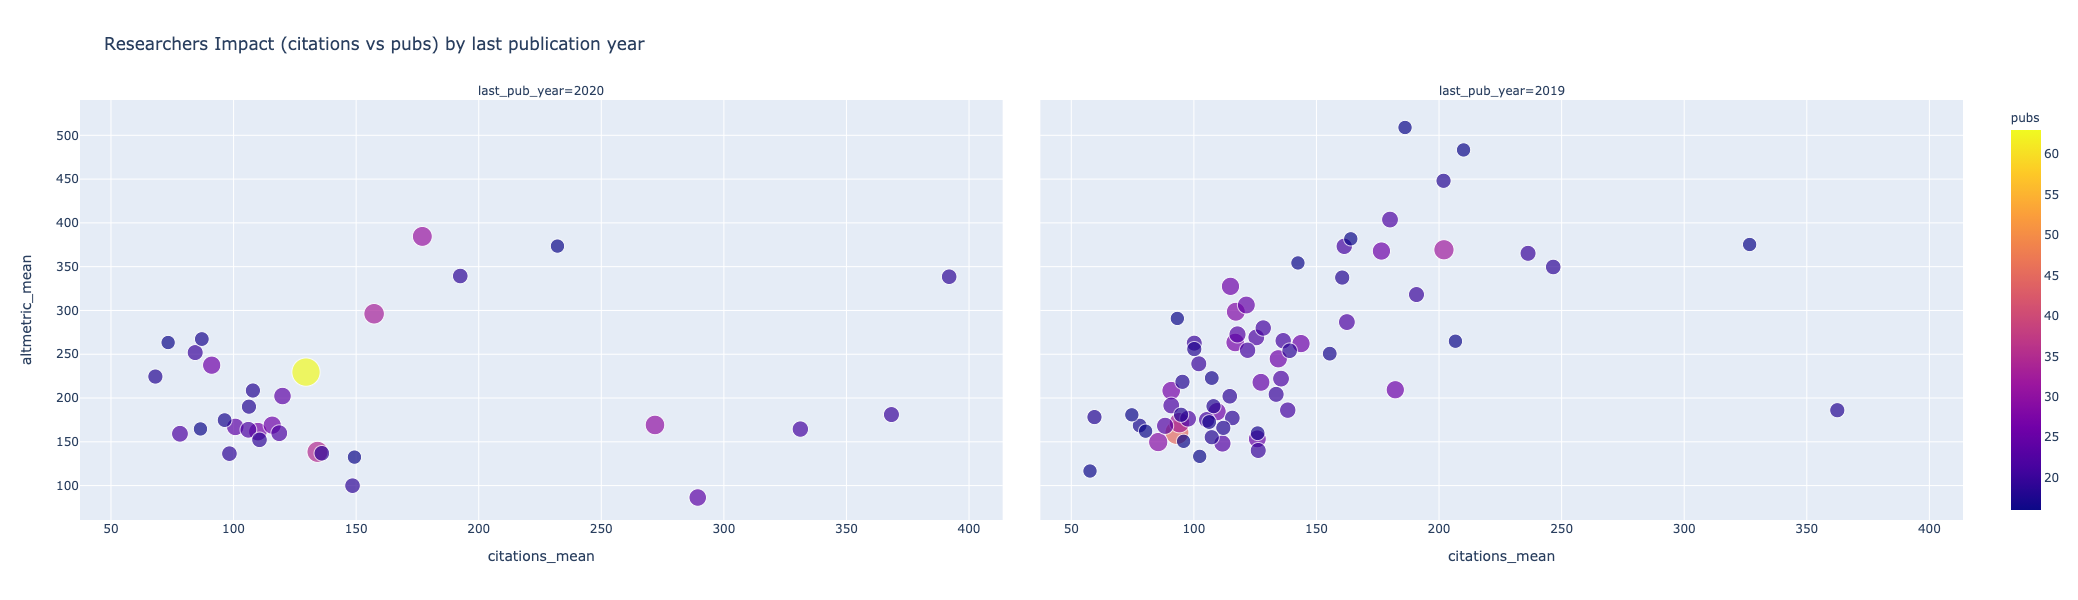

In [22]:
px.scatter(top100, 
           x="citations_mean", y="altmetric_mean", 
           hover_name="full_name", 
           hover_data=['pubs', 'citations_mean', 'altmetric_mean'], 
           color="pubs",
           size="pubs",
           facet_col="last_pub_year",
           height=600,
           title="Researchers Impact (citations vs pubs) by last publication year")